In [1]:
# code up SIRD model with deaths
# fit using adjoint method
# see how well it does on simulated data
# see how well it does on real data
# might have to play with noise parameter

!pip install jaxlib
!pip install jax

  Using cached jaxlib-0.1.51-cp38-none-manylinux2010_x86_64.whl (32.6 MB)
Processing /home/jovyan/.cache/pip/wheels/1d/10/8e/2f79b924179ff1e6510933d63eb851bea01054fff262343b7a/absl_py-0.9.0-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/c1/95/8e/f40e9bcab8ddbae34c8587e1188b68b265e77714e8fb6426eb/jax-0.1.72-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)


In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.nn
from jax import grad, jit, jacobian, random, vmap, lax
from jax.ops import index, index_update
from jax.experimental import ode

from sklearn import linear_model

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as onp

In [3]:
# fname = 'us-counties.csv'
# i = 0
# with open(fname, 'r') as in_file:
#     stripped = (line.strip() for line in in_file)
#     lines = (line.split(",") for line in stripped if 'Alameda' in line)
#     realdat = onp.array([list(map(int, (ln[4:]))) for ln in lines])
    
# print(realdat.shape)

In [4]:
def getnumrec(fname, ind):
    with open(fname, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        line = list(line.split(",") for line in stripped if line)[ind]
        return(onp.array(list(map(int, line[4:]))))

getnumrec('time_series_covid19_confirmed_global.csv', 227-1)

array([      1,       1,       2,       2,       5,       5,       5,
             5,       5,       7,       8,       8,      11,      11,
            11,      11,      11,      11,      11,      11,      12,
            12,      13,      13,      13,      13,      13,      13,
            13,      13,      15,      15,      15,      15,      15,
            15,      16,      16,      24,      30,      53,      73,
           104,     174,     222,     337,     451,     519,     711,
          1109,    1561,    2157,    2870,    2968,    4360,    6141,
          8917,   14157,   19479,   25825,   33761,   43850,   54112,
         66055,   84091,  102276,  122069,  141205,  162707,  188724,
        214205,  244610,  276547,  309699,  337573,  367215,  397992,
        429686,  464442,  497943,  527969,  556522,  581813,  608878,
        637974,  669272,  701996,  730337,  756375,  783716,  809318,
        837422,  871617,  907908,  940829,  968518,  990983, 1015518,
       1043038, 1072

In [11]:
# get line numbers for Indi
lnc = !awk 'BEGIN { FS = "," } ; { print $2 }' time_series_covid19_confirmed_global.csv | grep -n Germany | awk 'BEGIN {FS = ":"} ; { print $1 }'
lnd = !awk 'BEGIN { FS = "," } ; { print $2 }' time_series_covid19_deaths_global.csv | grep -n Germany | awk 'BEGIN {FS = ":"} ; { print $1 }'
lnr = !awk 'BEGIN { FS = "," } ; { print $2 }' time_series_covid19_recovered_global.csv | grep -n Germany | awk 'BEGIN {FS = ":"} ; { print $1 }'
linenos = list(map(int, [lnc[0], lnd[0], lnr[0]]))
print(linenos)

[122, 122, 114]


In [12]:
# get the numeric data corresponding to India's line numbers in each file
globc = getnumrec('time_series_covid19_confirmed_global.csv',linenos[0]-1)
globd = getnumrec('time_series_covid19_deaths_global.csv',linenos[1]-1)
globr = getnumrec('time_series_covid19_recovered_global.csv',linenos[2]-1)

# fudging the deaths
# globd[146:] -= 1650

In [37]:
# check that everybody has the same lenth
print(len(globc))
print(len(globd))
print(len(globr))

# population of India
# nn = 1.353e9
nn = 83.02e6

# put everything together
realdat = onp.vstack([ globc, globr, globd ]).T

# start time when there is >= 1 recorded death
si = 47
realdat = realdat[si:,:]
print(realdat[0,:])
print(realdat.shape)

178
178
178
[1176   18    2]
(131, 3)


                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:              -0.1219
Model:                       QuantReg   Bandwidth:                       2940.
Method:                 Least Squares   Sparsity:                        6310.
Date:                Wed, 22 Jul 2020   No. Observations:                  131
Time:                        06:18:32   Df Residuals:                      130
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0069      0.002      3.940      0.000       0.003       0.010


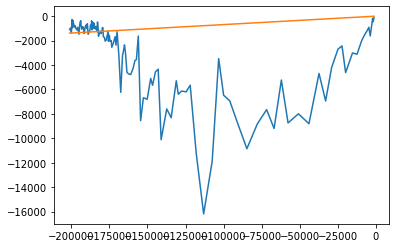

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:            -0.003248
Model:                       QuantReg   Bandwidth:                       1347.
Method:                 Least Squares   Sparsity:                        2783.
Date:                Wed, 22 Jul 2020   No. Observations:                  131
Time:                        06:18:33   Df Residuals:                      130
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0036      0.001      4.723      0.000       0.002       0.005


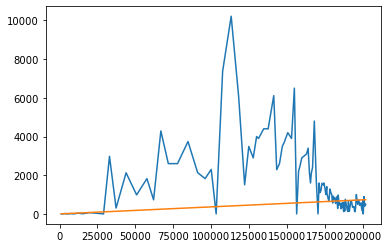

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:             -0.03284
Model:                       QuantReg   Bandwidth:                       79.56
Method:                 Least Squares   Sparsity:                        165.5
Date:                Wed, 22 Jul 2020   No. Observations:                  131
Time:                        06:18:33   Df Residuals:                      130
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001   4.58e-05      3.082      0.003    5.06e-05       0.000


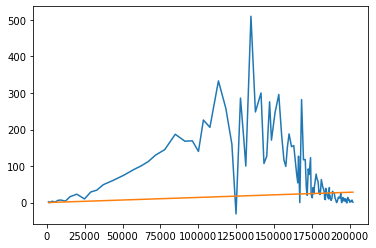

In [39]:
si = 47
globs = nn - (globc + globr + globd)
y = onp.diff(globs)
x = -globc*globs/nn

theta0 = onp.zeros(3)

import statsmodels.api as sm

y = y[(si-1):]
X = x[si:]

results = sm.regression.quantile_regression.QuantReg(y, X).fit(q=.5)
theta0[0] = results.params[0]
print(results.summary())

plt.plot(X,y)
plt.plot(X,theta0[0]*X)
plt.show()

y = onp.diff(globr)[(si-1):]
X = globc[si:]

results = sm.regression.quantile_regression.QuantReg(y, X).fit(q=.5)
theta0[1] = results.params[0]
print(results.summary())

plt.plot(X, y)
plt.plot(X, theta0[1]*X)
plt.show()

y = onp.diff(globd)[(si-1):]
results = sm.regression.quantile_regression.QuantReg(y, X).fit(q=.5)
theta0[2] = results.params[0]
print(results.summary())

plt.plot(X, y)
plt.plot(X, theta0[2]*X)
plt.show()

theta0 = onp.log(theta0)

In [40]:
npts = realdat.shape[0]
n = npts
lentheta = 3
d = 3
dt = 1.0
tint = np.arange(n)*dt

In [22]:
# theta = (beta, gamma, mu)
def sird(x, t, theta):
    s = nn - (x[0] + x[1] + x[2])
    stheta = np.exp(theta)
    idot = stheta[0]*s*x[0]/nn - stheta[1]*x[0] - stheta[2]*x[0]
    rdot = stheta[1]*x[0]
    ddot = stheta[2]*x[0]
    return np.array([idot, rdot, ddot])

In [23]:
# just-in-time (JIT) compiled version
fsird = jit(sird)

# use automatic differentiation and JIT together
mygradsird = jacobian(sird, 0)
fmygradsird = jit(mygradsird)

# use automatic differentiation and JIT together
mygradsirdtheta = jacobian(sird, 2)
fmygradsirdtheta = jit(mygradsirdtheta)


In [26]:
print(theta0)
xinit = 1.0*realdat[0,:]
x = lax.stop_gradient(ode.odeint(lambda y, t: fsird(y, t, theta0), t=tint, rtol=1e-9, atol=1e-9, y0=xinit)).T

[-5.38749245 -6.00307759 -9.80169894]


In [27]:
print(x[2,-1], realdat[-1,2])


9041.223399252469 9088


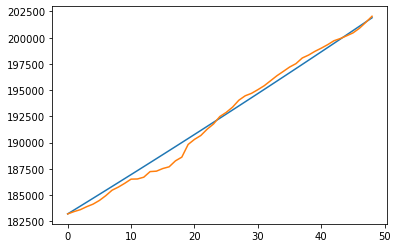

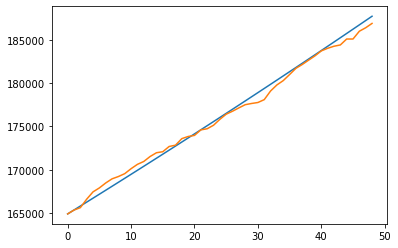

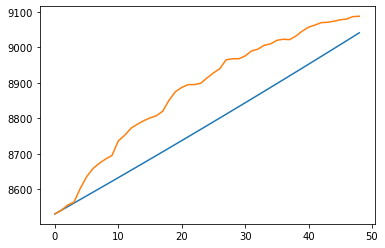

In [28]:
for i in range(3):
    plt.plot(x[i,:])
    plt.plot(realdat[:,i])
    plt.show()


In [20]:
# for scipy.optimize
# z should have (xinit, curtheta)
# note that the t variable is **not** passed in as z[0]
def newlagwithgrad(xinit, curtheta):
    # solves the forward ODE using our current estimates of xinit and curtheta
    fsirdI = lambda y, t: fsird(y, t, curtheta)
    x = lax.stop_gradient(ode.odeint(fsirdI, t=tint, rtol=1e-9, atol=1e-9, y0=xinit)).T
    
    # set up adjoint ODE
    fadj = lambda y, t: -np.matmul(y, fmygradsird(y, t, curtheta))
    icmat = np.eye(d)
    adjtint = np.array([0, dt])
    
    # function that solves the adjoint ODE once for one initial condition
    @jit
    def solonce(y0):
        adjsol = lax.stop_gradient(ode.odeint(fadj, t=adjtint, rtol=1e-9, atol=1e-9, y0=y0))
        return adjsol[1,:]
    
    # this is to solve the adjoint ODE for all initial conditions in the icmat **at once**
    propagator = vmap(solonce, in_axes=(0))(icmat) # + (1e-6)*np.eye(d)
    backprop = lax.stop_gradient(np.linalg.inv(propagator))

    yminusx = lax.stop_gradient(y - x)
    
    @jit
    def growlamb(i, lamb):
        lambplus = np.matmul(lamb[i,:], backprop)
        outlamb = index_update(lamb, index[i+1, :], lambplus + yminusx[:,(npts-2-i)])
        return outlamb
        
    initlamb = np.vstack([np.expand_dims(yminusx[:,(npts-1)],0), np.zeros((npts-1, d))])
    lambminus = lax.fori_loop(0, npts-1, growlamb, initlamb)
            
    # compute current value of lagrangian
    allxdot = np.hstack([(x[:,[1]]-x[:,[0]]), (x[:,2:] - x[:,:-2])/2, (x[:,[npts-2]]-x[:,[npts-3]])])/dt
    
    @jit
    def goodfun(i, lag):
        f = fsird(x[:, i], tint[i], curtheta)
        lag1 = lag + np.dot(lambminus[npts-1-i], allxdot[:,i]-f)*dt
        return lag1
        
    lag = lax.fori_loop(0, npts-1, goodfun, 0.0)
    lag += np.sum(np.square(x - y))/2.0
    
    # compute gradients using lamb (solution of adjoint ODE)
    # gradient of L with respect to parameters theta
    initgradtheta = np.zeros(lentheta)
    
    @jit
    def gt1i(i, gt):
        g = fmygradsirdtheta(x[:, i], tint[i], curtheta).reshape((d, lentheta))  # nabla_theta f
        gradtheta = gt - np.matmul(lambminus[npts-1-i],g)*dt
        return gradtheta
    
    gradtheta = lax.fori_loop(0, npts-1, gt1i, initgradtheta)
    gradx0 = -lambminus[npts-2]
    
    return lag, gradx0, gradtheta, x

In [21]:
lagwithgrad = jit(newlagwithgrad)

In [24]:
# adjoint solver with GD (gradient descent)
y = 1.0*realdat.T

# take as initial guess x = y
# theta0 = onp.log(onp.array([0.0564, 0.0227, 0.008]))
x0 = y[:,0] # + onp.random.normal(size=d)
x0[2] *= 1.6
print(x0)

maxiters = 9001
step = 5e-11

x = x0.copy()
theta = theta0.copy()

lag, gradx0, gradtheta, xest = lagwithgrad(x, theta)
print(onp.linalg.norm(gradtheta))
print(onp.linalg.norm(gradx0))

# mys = 1e-2
for i in range(maxiters):
    lag, gradx0, gradtheta, xest = lagwithgrad(x, theta)
    if i % 1000 == 0:
        mse = np.mean(np.square(xest - realdat.T), axis=1)
        print(lag, onp.exp(theta), x, mse)

    gradtheta /= 10000
    gradx0 /= 1000
    theta -= step*gradtheta
    x -= step*gradx0



[181827.  86936.   8296.]
2900567497295.803
7789576.573188773
72688375264.47153 [0.05792828 0.0222629  0.0007085 ] [181827.  86936.   8296.] [1.71770400e+09 1.18999387e+09 1.99082026e+06]
5503732648.139416 [0.0618886  0.02431927 0.00070749] [181827.00002975  86936.00000193   8295.99999772] [1.90928601e+08 2.90744508e+07 2.00865476e+06]
5503662331.504268 [0.06188816 0.02431927 0.00070705] [181827.00005588  86936.00000047   8295.99999545] [1.90928636e+08 2.90744623e+07 2.00568012e+06]
5503594410.643858 [0.06188773 0.02431927 0.00070662] [181827.00008202  86935.99999902   8295.9999932 ] [1.90928670e+08 2.90744736e+07 2.00280163e+06]
5503528720.4674 [0.06188731 0.02431927 0.0007062 ] [181827.00010815  86935.99999756   8295.99999095] [1.90928703e+08 2.90744848e+07 2.00001603e+06]
5503465185.202145 [0.06188689 0.02431927 0.00070578] [181827.00013429  86935.99999611   8295.99998871] [1.90928736e+08 2.90744957e+07 1.99732020e+06]
5503403731.806626 [0.06188648 0.02431927 0.00070537] [181827.000

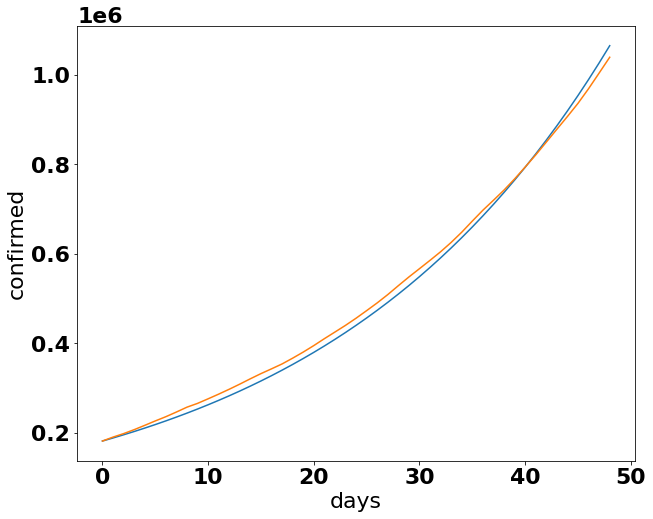

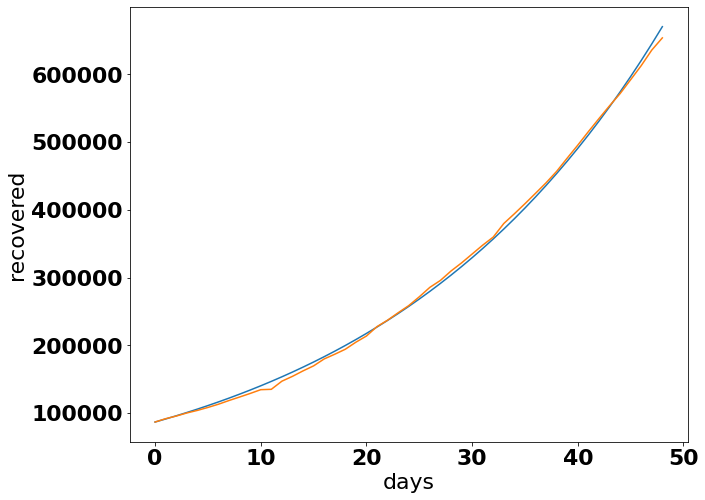

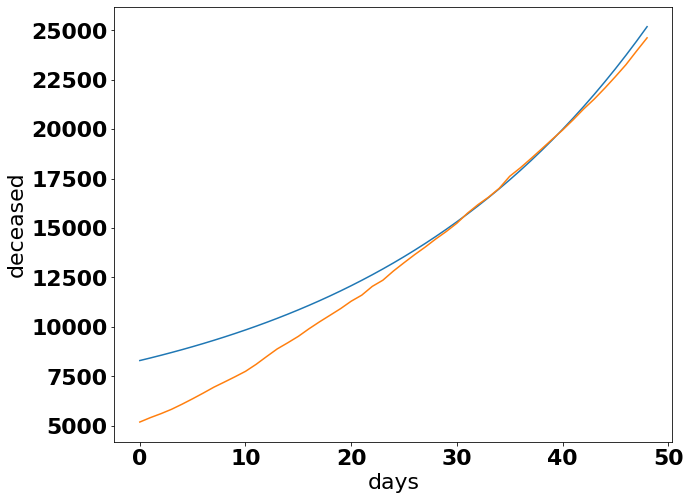

In [25]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

myxlab = 'days'
myylab = ['confirmed','recovered','deceased']
for i in range(3):
    plt.figure(figsize=(10,8))
    plt.plot(xest[i])
    plt.plot(realdat[:,i])
    plt.xlabel(myxlab)
    plt.ylabel(myylab[i])
    plt.show()

In [117]:
thetareal = onp.exp(theta)

In [118]:
r0 = thetareal[0]/(thetareal[1]+thetareal[2])
print(r0)

2.59416389698005


In [70]:
globd

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     1,     1,     2,     2,     2,
           2,     3,     3,     4,     5,     4,     7,    10,    10,
          12,    20,    20,    24,    27,    32,    35,    58,    72,
          72,    86,    99,   136,   150,   178,   226,   246,   288,
         331,   358,   393,   405,   448,   486,   521,   559,   592,
         645,   681,   721,   780,   825,   881,   939,  1008,  1079,
        1154,  1223,  1323,  1391,  1566,  1693,  1785,  1889,  1985,
        2101,  2212,  2294,  2415,  2551,  2649,  2753,  2871,  3025,
        3156,  3302,  3434,  3584,  3726,  3868,  4024,  4172,  4344,
        4534,  4711,

In [71]:
onp.diff(globd)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    1,    0,    1,    0,    0,    0,    1,
          0,    1,    1,   -1,    3,    3,    0,    2,    8,    0,    4,
          3,    5,    3,   23,   14,    0,   14,   13,   37,   14,   28,
         48,   20,   42,   43,   27,   35,   12,   43,   38,   35,   38,
         33,   53,   36,   40,   59,   45,   56,   58,   69,   71,   75,
         69,  100,   68,  175,  127,   92,  104,   96,  116,  111,   82,
        121,  136,   98,  104,  118,  154,  131,  146,  132,  150,  142,
        142,  156,  148,  172,  190,  177,  269,  205,  223,  200,  221,
        259,  275,  286,  297,  261,  266,  277,  352,  396,  386,  311,
        325,  380, 2003,  334,  336,  375,  306,  4

In [75]:
onp.diff(globd)[145]

2003

In [26]:
print(x)

[181827.00023886  86935.99999028   8295.99997984]


In [30]:
fortint = np.arange(365*2)*dt
forx = lax.stop_gradient(ode.odeint(lambda y, t: fsird(y, t, theta), t=fortint, rtol=1e-9, atol=1e-9, y0=x)).T

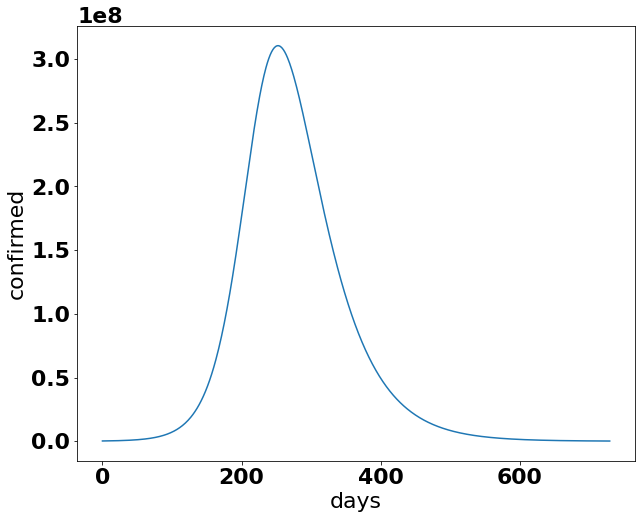

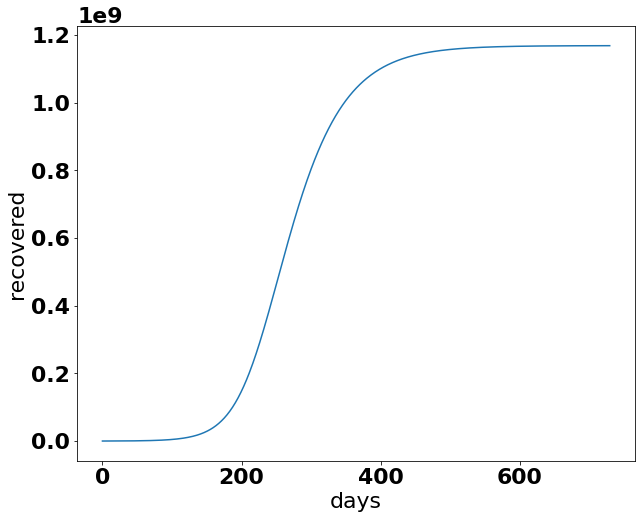

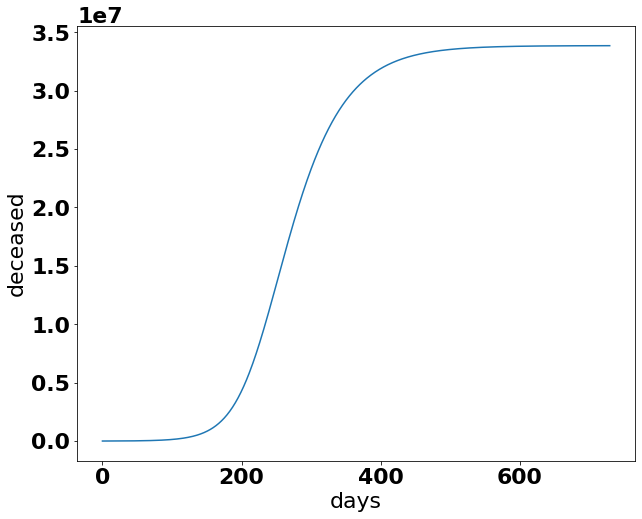

In [31]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

myxlab = 'days'
myylab = ['confirmed','recovered','deceased']
for i in range(3):
    plt.figure(figsize=(10,8))
    plt.plot(forx[i])
    plt.xlabel(myxlab)
    plt.ylabel(myylab[i])
    plt.show()